In [1]:
# Using OSMnx and NetworkX to calculate quickest routes to nearest cooling centers

# Code for evaluate distances from census tract centroids.
# Citiation:
# Boeing, G. 2024. “Modeling and Analyzing Urban Networks and Amenities with OSMnx.” 
# Working paper. https://geoffboeing.com/publications/osmnx-paper/


# Steps:
# 1. Load Des Moines area shapefile 
# 2. Load cooling center centroid shapefile
# 3. Generate graph network for Des Moines area
# 4. Find the nearest cooling center for each census tract. 
# 5. Calculate driving distance from each census to the nearest cooling center. 
# 6. Explore results and save as csv. 

In [1]:
# pip install --upgrade pip
# pip install --upgrade matplotlib
# !pip install osmnx
# pip install shapely
# pip install networkx

In [1]:
import osmnx as os
import geopandas as gpd
import pandas as pd
import matplotlib
import networkx as nx
import shapely
import pyproj
from shapely.geometry import Point
from shapely.ops import nearest_points

C:\Users\babyn\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


<Axes: >

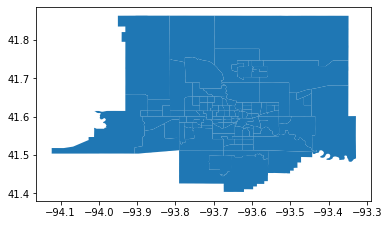

In [2]:
# Greater Des Moines area shapefile
file = r"file_path/file.shp"
# Read and plot the data
dsm = gpd.read_file(file)
dsm.head()
dsm.plot()

<Axes: >

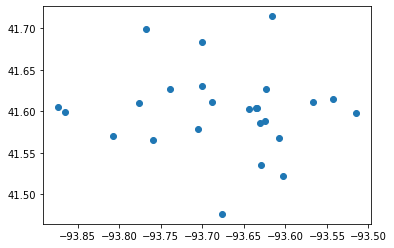

In [3]:
# Cooling centers shapefile
file2 = r"file_path/file.shp"
# Read and plot the data
cooling_centers = gpd.read_file(file2)
cooling_centers.head()
cooling_centers.plot()

In [4]:
# projection for dsm shapefile and cooling center shapefile
dsm = dsm.to_crs('EPSG:26915')
cooling_centers = cooling_centers.to_crs('EPSG:26915')

In [5]:
# Generate osmnx graph. This line will provide you with road networks from Open Street Map. 
# Combine all census tracts into one polygon to get road netorks for entire study area
polygon = dsm.unary_union.convex_hull
G = os.graph_from_polygon(polygon, network_type='drive', simplify=True)

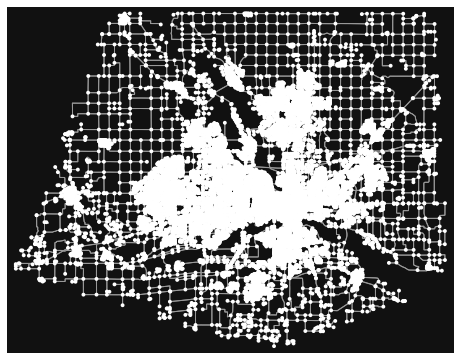

(<Figure size 576x576 with 1 Axes>, <Axes: >)

In [26]:
# View the road network
os.plot_graph(G)

In [6]:
undirected_G = G.to_undirected()
connected_components = list(nx.connected_components(undirected_G))

In [7]:
# Function to get the nearest node ID based on latitude and longitude
def get_nearest_node(lat, lon):
    return os.nearest_nodes(G, lon, lat,)

In [8]:
# Get the node that is the nearest to each census tract centroid
for index, row in dsm.iterrows():
    centroid = row.geometry.centroid
    centroid_lon, centroid_lat = centroid.x, centroid.y
    nearest_node_id = get_nearest_node(centroid_lat, centroid_lon)
    dsm.loc[index, 'Nearest_Node_ID'] = nearest_node_id

In [10]:
# Get the node that is the nearest to each cooling center
for index, row in cooling_centers.iterrows():
    centroid = row.geometry.centroid
    centroid_lon, centroid_lat = centroid.x, centroid.y
    nearest_node_id = get_nearest_node(centroid_lat, centroid_lon)
    cooling_centers.loc[index, 'Cooling_Center_ID'] = nearest_node_id

In [11]:
# Iterate over each row in dsm
for index, row in dsm.iterrows():
    # storing nearest cooling center and minimum distance
    nearest_cc_info = None
    min_distance = float('inf')
    
    # Get the nearest node ID for the current row
    nearest_node = row['Nearest_Node_ID']
    
    # Iterate over each cooling center to find the nearest one
    for cc_idx, cc_row in cooling_centers.iterrows():
        try:
            # Calculate the distance from the nearest node to the cooling center
            distance = nx.shortest_path_length(G, source=nearest_node, target=cc_row['Cooling_Center_ID'], weight='length_mi')
            
            # Update nearest cooling center info if this center is closer than the previous one
            if distance < min_distance:
                min_distance = distance
                nearest_cc_info = {
                    'Cooling_Center_ID': cc_row['Cooling_Center_ID'],
                    'Cooling_Center_Name': cc_row['USER_name'],
                    'Distance_Minutes': distance / 30 * 60 
                }
        except nx.NetworkXNoPath:
            # Handle the case where no path exists between the nearest node and the cooling center
            print(f"No path found from nearest node {nearest_node} to cooling center {cc_row['Cooling_Center_ID']}.")
            continue
    
    # Add nearest cooling center info to dsm
    if nearest_cc_info:
        dsm.at[index, 'Nearest_cc'] = nearest_cc_info['Cooling_Center_Name']
        dsm.at[index, 'Nearest_cc_ID'] = nearest_cc_info['Cooling_Center_ID']
        dsm.at[index, 'Distance_Minutes'] = nearest_cc_info['Distance_Minutes']


dsm.head(10)


No path found from nearest node 1390286839.0 to cooling center 160775687.0.
No path found from nearest node 1390286839.0 to cooling center 160854573.0.
No path found from nearest node 1390286839.0 to cooling center 160890760.0.
No path found from nearest node 1390286839.0 to cooling center 160966462.0.
No path found from nearest node 1390286839.0 to cooling center 160848580.0.
No path found from nearest node 1390286839.0 to cooling center 160950512.0.
No path found from nearest node 1390286839.0 to cooling center 160945827.0.
No path found from nearest node 1390286839.0 to cooling center 2267243671.0.
No path found from nearest node 1390286839.0 to cooling center 559704333.0.
No path found from nearest node 1390286839.0 to cooling center 160911788.0.
No path found from nearest node 1390286839.0 to cooling center 160872954.0.
No path found from nearest node 1390286839.0 to cooling center 160816148.0.
No path found from nearest node 1390286839.0 to cooling center 160742193.0.
No path fou

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,TRACT,geometry,Nearest_Node_ID,Nearest_cc,Nearest_cc_ID,Distance_Minutes
0,19153001800,Iowa,Polk County,0.51,0.27,0.57,0.66,0.46,0.00,0.72,...,0.0,0.0,Nation,21,001800,"POLYGON ((-93.569 41.600, -93.569 41.600, -93....",161000446.0,East Side Library,1.607757e+08,14.0
1,19153004004,Iowa,Polk County,0.21,0.07,0.31,0.39,0.06,0.74,0.72,...,0.0,0.0,Nation,21,004004,"POLYGON ((-93.666 41.548, -93.674 41.548, -93....",160967293.0,South Side Library,1.609118e+08,30.0
2,19153010207,Iowa,Polk County,0.07,0.14,0.12,0.33,0.10,0.39,0.72,...,0.0,0.0,Nation,21,010207,"POLYGON ((-93.654 41.728, -93.654 41.730, -93....",160816081.0,Ankeny Kirkendall Public Library,7.220633e+09,32.0
3,19153010208,Iowa,Polk County,0.06,0.12,0.13,0.35,0.15,0.36,0.72,...,0.0,0.0,Nation,21,010208,"POLYGON ((-93.610 41.743, -93.610 41.741, -93....",160852534.0,Ankeny Kirkendall Public Library,7.220633e+09,32.0
4,19153010209,Iowa,Polk County,0.07,0.14,0.13,0.46,0.12,0.51,0.72,...,0.0,0.0,Nation,21,010209,"POLYGON ((-93.570 41.738, -93.570 41.738, -93....",160802816.0,Pleasant Hill Public Library,1.608188e+08,60.0
5,19153010211,Iowa,Polk County,0.22,0.06,0.51,0.47,0.15,0.79,0.72,...,0.0,0.0,Nation,21,010211,"POLYGON ((-93.594 41.723, -93.595 41.723, -93....",160795506.0,Pleasant Hill Public Library,1.608188e+08,50.0
6,19153010212,Iowa,Polk County,0.15,0.10,0.29,0.51,0.15,0.78,0.72,...,0.0,0.0,Nation,21,010212,"POLYGON ((-93.562 41.703, -93.562 41.703, -93....",160818464.0,Ankeny Kirkendall Public Library,7.220633e+09,30.0
7,19153010406,Iowa,Polk County,0.14,0.09,0.23,0.65,0.10,0.61,0.72,...,0.0,0.0,Nation,21,010406,"POLYGON ((-93.756 41.652, -93.756 41.649, -93....",160957609.0,Urbandale Public Library,1.608312e+08,16.0
8,19153010407,Iowa,Polk County,0.19,0.06,0.27,0.61,0.04,0.59,0.73,...,0.0,0.0,Nation,21,010407,"POLYGON ((-93.756 41.648, -93.756 41.648, -93....",160901115.0,Urbandale Public Library,1.608312e+08,40.0
9,19153010408,Iowa,Polk County,0.35,0.16,0.55,0.65,0.21,0.00,0.72,...,0.0,0.0,Nation,21,010408,"POLYGON ((-93.704 41.624, -93.704 41.624, -93....",160900928.0,Merle Hay Mall,2.267244e+09,14.0


In [12]:
# Average time?
avg_time = dsm['Distance_Minutes'].mean()
print(avg_time)

28.345454545454544


In [13]:
# Max time?
max_time = dsm['Distance_Minutes'].max()
print(max_time)

66.0


In [14]:
# Min time?
min_time = dsm['Distance_Minutes'].min()
print(min_time)

2.0


In [15]:
cooling_centers.head()

,Loc_name,Status,Score,Match_type,Match_addr,LongLabel,ShortLabel,Addr_type,Type,PlaceName,...,IN_SingleL,USER_id,USER_name,USER_addre,USER_st_ad,USER_city,USER_state,USER_zip,geometry,Cooling_Center_ID
0,World,M,100.0,A,"2559 Hubbell Ave, Des Moines, Iowa, 50317","2559 Hubbell Ave, Des Moines, IA, 50317, USA",2559 Hubbell Ave,PointAddress,None,None,...,"2559 Hubbell Ave, Des Moines, IA 50317",3,East Side Library,"2559 Hubbell Ave, Des Moines, IA 50317",2559 Hubbell Ave,Des Moines,Iowa,50317,POINT (-93.567 41.611),160775687.0
1,World,M,100.0,A,"1000 Grand Ave, Des Moines, Iowa, 50309","1000 Grand Ave, Des Moines, IA, 50309, USA",1000 Grand Ave,PointAddress,None,None,...,"1000 Grand Ave, Des Moines, IA 50309",1,Central Library,"1000 Grand Ave, Des Moines, IA 50309",1000 Grand Ave,Des Moines,Iowa,50309,POINT (-93.631 41.586),160854573.0
2,World,M,100.0,A,"1326 Forest Ave, Des Moines, Iowa, 50314","1326 Forest Ave, Des Moines, IA, 50314, USA",1326 Forest Ave,PointAddress,None,None,...,"1326 Forest Ave, Des Moines, IA 50314",4,Forest Avenue Library,"1326 Forest Ave, Des Moines, IA 50314",1326 Forest Ave,Des Moines,Iowa,50314,POINT (-93.636 41.604),160890760.0
3,World,M,100.0,A,"5000 Franklin Ave, Des Moines, Iowa, 50310","5000 Franklin Ave, Des Moines, IA, 50310, USA",5000 Franklin Ave,PointAddress,None,None,...,"5000 Franklin Ave, Des Moines, IA 50310",6,Franklin Avenue Library,"5000 Franklin Ave, Des Moines, IA 50310",5000 Franklin Ave,Des Moines,Iowa,50310,POINT (-93.688 41.611),160966462.0
4,World,M,100.0,A,"3711 Easton Blvd, Des Moines, Iowa, 50317","3711 Easton Blvd, Des Moines, IA, 50317, USA",3711 Easton Blvd,PointAddress,None,None,...,"3711 Easton Blvd, Des Moines, IA 50317",5,Fourmile Community Recreation Center,"3711 Easton Blvd, Des Moines, IA 50317",3711 Easton Blvd,Des Moines,Iowa,50317,POINT (-93.543 41.614),160848580.0


In [16]:
cooling_centers.head()

,Loc_name,Status,Score,Match_type,Match_addr,LongLabel,ShortLabel,Addr_type,Type,PlaceName,...,IN_SingleL,USER_id,USER_name,USER_addre,USER_st_ad,USER_city,USER_state,USER_zip,geometry,Cooling_Center_ID
0,World,M,100.0,A,"2559 Hubbell Ave, Des Moines, Iowa, 50317","2559 Hubbell Ave, Des Moines, IA, 50317, USA",2559 Hubbell Ave,PointAddress,None,None,...,"2559 Hubbell Ave, Des Moines, IA 50317",3,East Side Library,"2559 Hubbell Ave, Des Moines, IA 50317",2559 Hubbell Ave,Des Moines,Iowa,50317,POINT (-93.567 41.611),160775687.0
1,World,M,100.0,A,"1000 Grand Ave, Des Moines, Iowa, 50309","1000 Grand Ave, Des Moines, IA, 50309, USA",1000 Grand Ave,PointAddress,None,None,...,"1000 Grand Ave, Des Moines, IA 50309",1,Central Library,"1000 Grand Ave, Des Moines, IA 50309",1000 Grand Ave,Des Moines,Iowa,50309,POINT (-93.631 41.586),160854573.0
2,World,M,100.0,A,"1326 Forest Ave, Des Moines, Iowa, 50314","1326 Forest Ave, Des Moines, IA, 50314, USA",1326 Forest Ave,PointAddress,None,None,...,"1326 Forest Ave, Des Moines, IA 50314",4,Forest Avenue Library,"1326 Forest Ave, Des Moines, IA 50314",1326 Forest Ave,Des Moines,Iowa,50314,POINT (-93.636 41.604),160890760.0
3,World,M,100.0,A,"5000 Franklin Ave, Des Moines, Iowa, 50310","5000 Franklin Ave, Des Moines, IA, 50310, USA",5000 Franklin Ave,PointAddress,None,None,...,"5000 Franklin Ave, Des Moines, IA 50310",6,Franklin Avenue Library,"5000 Franklin Ave, Des Moines, IA 50310",5000 Franklin Ave,Des Moines,Iowa,50310,POINT (-93.688 41.611),160966462.0
4,World,M,100.0,A,"3711 Easton Blvd, Des Moines, Iowa, 50317","3711 Easton Blvd, Des Moines, IA, 50317, USA",3711 Easton Blvd,PointAddress,None,None,...,"3711 Easton Blvd, Des Moines, IA 50317",5,Fourmile Community Recreation Center,"3711 Easton Blvd, Des Moines, IA 50317",3711 Easton Blvd,Des Moines,Iowa,50317,POINT (-93.543 41.614),160848580.0


In [17]:
dsm.head()

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,TRACT,geometry,Nearest_Node_ID,Nearest_cc,Nearest_cc_ID,Distance_Minutes
0,19153001800,Iowa,Polk County,0.51,0.27,0.57,0.66,0.46,0.00,0.72,...,0.0,0.0,Nation,21,001800,"POLYGON ((-93.569 41.600, -93.569 41.600, -93....",161000446.0,East Side Library,1.607757e+08,14.0
1,19153004004,Iowa,Polk County,0.21,0.07,0.31,0.39,0.06,0.74,0.72,...,0.0,0.0,Nation,21,004004,"POLYGON ((-93.666 41.548, -93.674 41.548, -93....",160967293.0,South Side Library,1.609118e+08,30.0
2,19153010207,Iowa,Polk County,0.07,0.14,0.12,0.33,0.10,0.39,0.72,...,0.0,0.0,Nation,21,010207,"POLYGON ((-93.654 41.728, -93.654 41.730, -93....",160816081.0,Ankeny Kirkendall Public Library,7.220633e+09,32.0
3,19153010208,Iowa,Polk County,0.06,0.12,0.13,0.35,0.15,0.36,0.72,...,0.0,0.0,Nation,21,010208,"POLYGON ((-93.610 41.743, -93.610 41.741, -93....",160852534.0,Ankeny Kirkendall Public Library,7.220633e+09,32.0
4,19153010209,Iowa,Polk County,0.07,0.14,0.13,0.46,0.12,0.51,0.72,...,0.0,0.0,Nation,21,010209,"POLYGON ((-93.570 41.738, -93.570 41.738, -93....",160802816.0,Pleasant Hill Public Library,1.608188e+08,60.0


In [18]:
# save the results
dsm.to_csv(r"file_path/file.csv")